## Social vulnerability and Covid-19 in Chile

0. A first look at the DataFrames
1. Covid-19 in Chile
    1. Covid-19 in Chile and worldwide
    2. Timeline of Covid-19 cases and deaths in Chile 
    3. Which are the 10 most affected districts in Chile, regarding cases and deaths
    
2. Analyze the CASEN data: The ten most affected districts
    1. Correlation between the CASEN social indicators and cases/deaths in the ten most affected districts
    2. Analyze six selected CASEN social indicators for the ten most affected districts
    3. Correlation between six selected CASEN social indicators and cases/deaths for most affected districts

3. Analyze the CASEN data: The ten less affected districts
    1. Correlation between the CASEN social indicators and cases/deaths in the ten less affected districts

In [1]:
# Read in libraries
import pandas as pd
pd.options.mode.chained_assignment = None  

import numpy as np

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns
import imgkit


# Read in CASEN data about social vulnerability
casen = pd.read_stata('Casen 2017.dta', convert_categoricals = False)

# Read in data about Covid-19 cases and deaths in Chilean regions
cases_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto3/CasosTotalesCumulativo_T.csv',
    parse_dates = True)

deaths_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo_T.csv',
    parse_dates = True)

# Read in data about Covid-19 in Chilean districts
cases_districts = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv')
cases_districts = cases_districts[~cases_districts.Comuna.str.contains('Desconocido')]

deaths_districts = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto38/CasosFallecidosPorComuna.csv')
deaths_districts = deaths_districts[~deaths_districts.Comuna.str.contains('Desconocido')]
deaths_districts = deaths_districts[~deaths_districts.Comuna.str.contains('Total')]



# Read in data about Covid-19 worldwide
csse_cases_all = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

csse_all_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/07-27-2020.csv')

csse_deaths_all = pd.read_csv(
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [2]:
# Read in World Bank data about population
worldbank_population = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_1217749.csv', skiprows = range(3))
worldbank_population = worldbank_population.iloc[:, [0, 1, -2]]

# Unforunately, the World Bank country names are not in all cases the same as the CSSE country names. Therefore
# some renaming is necessary. 
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('United States', 'US')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Yemen, Rep.', 'Yemen')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Myanmar', 'Burma')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('St. Kitts and Nevis', 'Saint Kitts and Nevis')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Syrian Arab Republic', 'Syria')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Venezuela, RB', 'Venezuela')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Slovak Republic', 'Slovakia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('St. Vincent and the Grenadines', 'Saint Vincent and the Grenadines')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('St. Lucia', 'Saint Lucia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Russian Federation', 'Russia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Kyrgyz Republic', 'Kyrgyzstan')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Korea, Rep.', 'Korea, South')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Iran, Islamic Rep.', 'Iran')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Gambia, The', 'Gambia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Egypt, Arab Rep.', 'Egypt')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Czech Republic', 'Czechia')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Congo, Dem. Rep.', 'Congo (Kinshasa)')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Congo, Rep.', 'Congo (Brazzaville)')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Brunei Darussalam', 'Brunei')
worldbank_population['Country Name'] = worldbank_population['Country Name'].replace('Bahamas, The', 'Bahamas')


In [3]:
# Select only 46 relevant indicators from the CASEN study, such as poverty, access to health institutions or
# number of persons in household. 

casen_columns = ['region', 'provincia', 'comuna', 'e1', 'e6a', 'o1', 'o12', 'o16', 'o25a_min',
                'o25c', 'o28', 'y21a', 'y22a', 'y24', 'y27a', 'ysub', 'ytot', 's12', 's13', 's14', 
                's26a', 's27a', 's28', 's31a1', 's32c', 's33g1', 's33i1', 's33j1',
                'r1a', 'r3', 'r7c', 'r8a', 'r8b', 'r16a', 'r16b', 'v33', 'v37a', 'v37c',
                'v37i', 'v39b', 'pobreza', 'hh_d_prevs', 'hh_d_cot', 'hh_d_servbas', 'qaut', 'numper']

casen_rel = casen[casen_columns]

# Important question: There are a lot of NaNs in the CASEN data. How to handle them? 
# Options: Fill with mean, fill with median, drop (would leave not DataFrame)


## 0. A first look at the DataFrames

A first look at the DataFrames shows that the CASEN data has a lot of NaNs. E.g. the variable s32c ('Do you have difficulties with moving within your house?') has a very high percentage of NaNs. Other possible variables (option 2 and 3 for 'permament conditions'), that I found interesting at first, had more than 97% of NaNs which is why I dropped them.  

Interestingly, other indicators that are about not having enough money to buy food or having a water heater at home have the same share of NaNs, which is 67%. 

In [4]:
def first_look(lst):
    """
    Provides useful information about a list of dataframes: Name, Shape, NaNs and describe().
    
    Input: 
        lst(List): List of DataFrames
    
    Output: 
        Prints name, shape, share of NaNs, describe()
    """
    for item in lst:
        def get_df_name(df):
            name =[x for x in globals() if globals()[x] is df][0]
            return name
        print('Information for DataFrame ' + get_df_name(item))
        print('The shape of this DataFrame is {}.'.format(item.shape))
        print('NaN share for each column:')
        print((np.sum(item.isna() == True))/item.shape[0])
        print('Describe() for each column:')
        print(item.describe())
        print('---')

In [5]:
df_list = [casen_rel, cases_regions, deaths_regions, cases_districts, deaths_districts, csse_cases_all, csse_deaths_all]

first_look(df_list)

Information for DataFrame casen_rel
The shape of this DataFrame is (216439, 46).
NaN share for each column:
region          0.000000
provincia       0.000000
comuna          0.000000
e1              0.191107
e6a             0.000000
o1              0.191107
o12             0.573011
o16             0.682913
o25a_min        0.573011
o25c            0.625299
o28             0.191107
y21a            0.615448
y22a            0.000000
y24             0.672203
y27a            0.191107
ysub            0.712524
ytot            0.331424
s12             0.000000
s13             0.000000
s14             0.615448
s26a            0.000000
s27a            0.000000
s28             0.000000
s31a1           0.000000
s32c            0.881713
s33g1           0.191107
s33i1           0.191107
s33j1           0.191107
r1a             0.000000
r3              0.000000
r7c             0.672203
r8a             0.672203
r8b             0.672203
r16a            0.672203
r16b            0.672203
v33             0

       Codigo region  Codigo comuna      Poblacion  2020-03-30  2020-04-01  \
count     346.000000     346.000000     346.000000  343.000000  346.000000   
mean        8.797688    9034.997110   56237.890173    5.647230    8.141618   
std         3.847016    3818.147431   88945.967089   19.022787   25.224560   
min         1.000000    1101.000000     137.000000    0.000000    0.000000   
25%         6.000000    6109.250000    9649.250000    0.000000    0.000000   
50%         8.000000    8313.500000   19770.000000    0.000000    0.000000   
75%        13.000000   13102.750000   55441.250000    0.000000    5.000000   
max        16.000000   16305.000000  645909.000000  181.000000  225.000000   

       2020-04-03  2020-04-06  2020-04-08  2020-04-10  2020-04-13  ...  \
count   346.00000  346.000000  346.000000  346.000000  346.000000  ...   
mean     10.15896   13.254335   15.300578   18.138728   21.621387  ...   
std      31.03781   38.455380   42.803249   49.523508   56.388132  ...   
m

Length: 197, dtype: float64
Describe() for each column:
              Lat        Long     1/22/20     1/23/20     1/24/20     1/25/20  \
count  266.000000  266.000000  266.000000  266.000000  266.000000  266.000000   
mean    21.076624   22.829441    0.063910    0.067669    0.097744    0.157895   
std     24.904600   70.191330    1.042337    1.043908    1.473615    2.453621   
min    -51.796300 -135.000000    0.000000    0.000000    0.000000    0.000000   
25%      6.677575  -15.277675    0.000000    0.000000    0.000000    0.000000   
50%     22.820850   20.921188    0.000000    0.000000    0.000000    0.000000   
75%     41.143200   77.913685    0.000000    0.000000    0.000000    0.000000   
max     71.706900  178.065000   17.000000   17.000000   24.000000   40.000000   

          1/26/20     1/27/20     1/28/20     1/29/20  ...        7/23/20  \
count  266.000000  266.000000  266.000000  266.000000  ...     266.000000   
mean     0.210526    0.308271    0.492481    0.500000  ...  

## 1. Covid-19 in Chile

###     A. Covid-19 in Chile and worldwide

First, lets have a look at the spread of Covid-19 in Chile and worldwide. Therefore, we compare the number of cases and deaths per 100.000 habitants. 

In [6]:
def plot_covid_worldwide(df, title, country, m, z=100000, t=100000):
    """
    Function to plot a comparison between the m-most affected countries (as per z habitants) 
    and a specific country, which is highlighted in red. 
    
    If the specific country is not wihtin the m-most affected countries, it is appended at the end. 
    
    Input: 
        df (DataFrame): DataFrame with country data
        title (string): Specify the kind of the plot (cases or deaths) 
        country (string): The country that sould be highlighted
        m (int): Returns the m-most affected countries. 
        z (int): Number to calculate the cases per z habitants
        t (int): Number of minimal population for a country to be considered (standard: 100.000)
        
    Output: 
        A seaborn plot. 
    """
    
    # Get the relevant columns of df (Countryname and total number) and add a new column
    # of cases/deaths per z habitants. Rename the columns. 
    df_current = df.iloc[:, [1, -1]]
    df_current.columns = ['Country', title]

    # Merge World Bank population data with DataFrame
    df_final = df_current.merge(worldbank_population, left_on = 'Country', right_on = 'Country Name', how = 'left')
    df_final = df_final.drop(['Country Name', 'Country Code'], axis = 1)
    df_final.columns = ['Country', title, 'population']

    # Calculate cases per z habitants
    df_final.loc[:, 'per {} habitants'.format(z)] = (df_final.loc[:, title] / df_final.loc[:, 'population']) * z

    # Drop rows of countries that are below z
    rows_to_drop = []

    for i in range(len(df_final.population)):
        if df_final.population[i] < t:
            rows_to_drop.append(i)

    df_final = df_final.drop(rows_to_drop, axis = 0)


    # Groupby country and get the m-most affected countries. 
    df_final = df_final.groupby(
        'Country')[
        'per {} habitants'.format(z)].sum().reset_index().sort_values([
        'per {} habitants'.format(z)], ascending = False)
    
    # Show only the top m countries
    df_final_head = df_final.head(m)

    # Check if specific country is part of the m-most affected countries
    if country in list(df_final_head.Country) == True:

        # Get index of specific country in country list
        index = list(df_final_head.Country).index(country)

        # Plot the figure
        f = plt.figure(figsize = (16, 10))
        ax = f.add_subplot(1,1,1)

        ax = sns.barplot(y = df_final_head['Country'], x = df_final_head['per 100.000'], color = 'darkgrey')
        plt.ylabel('Country', fontsize = 12)
        plt.xlabel('{} per {} habitants'.format(title, z), fontsize = 12)
        plt.title('Covid-19 {} per {} habitants worldwide'.format(title, z), fontsize = 12)
        ax.get_children()[index].set_color('darkred') 

        plt.tick_params(labelsize=12)

        plt.grid(False)
        ax.xaxis.grid()
        sns.despine()
        plt.show()


    # If the specific country is not within the m-most affected countries, append it to the list
    else:

        df_final_head = df_final_head.append(df_final[df_final['Country'] == country])
        index = list(df_final_head.Country).index(country)

        f = plt.figure(figsize = (16, 10))
        ax = f.add_subplot(1,1,1)

        ax = sns.barplot(y = df_final_head['Country'], x = df_final_head['per {} habitants'.format(z)], color = 'darkgrey')
        plt.ylabel('Country', fontsize = 12)
        plt.xlabel('{} per {} habitants'.format(title, z), fontsize = 12)
        plt.title('Covid-19 {} per {} habitants worldwide'.format(title, z), fontsize = 12)
        ax.get_children()[index].set_color('darkred') 

        plt.tick_params(labelsize=12)

        plt.grid(False)
        ax.xaxis.grid()
        sns.despine()
        plt.show()

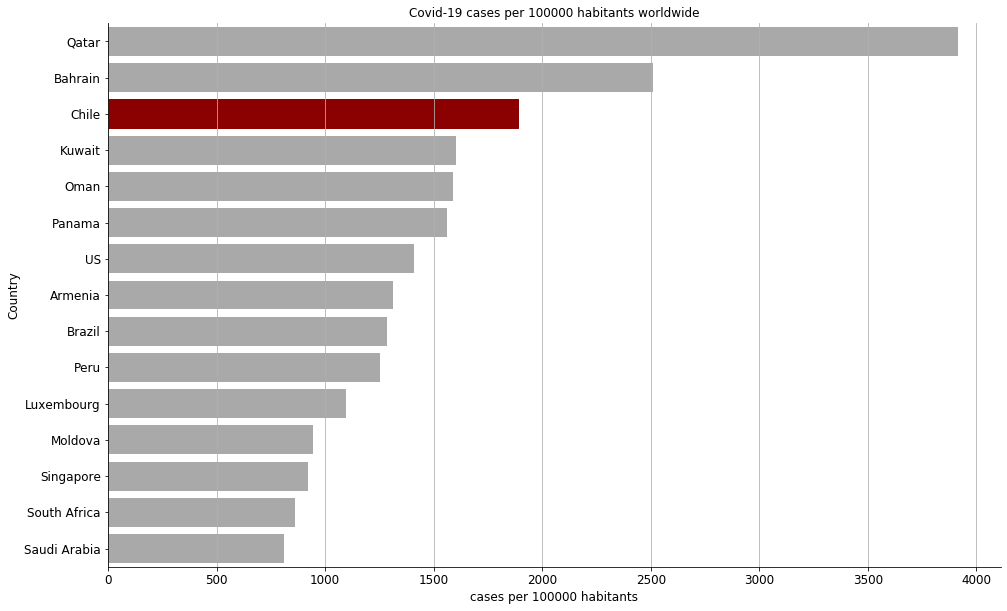

In [7]:
plot_covid_worldwide(csse_cases_all, 'cases', 'Chile', 15, 100000, 100000)

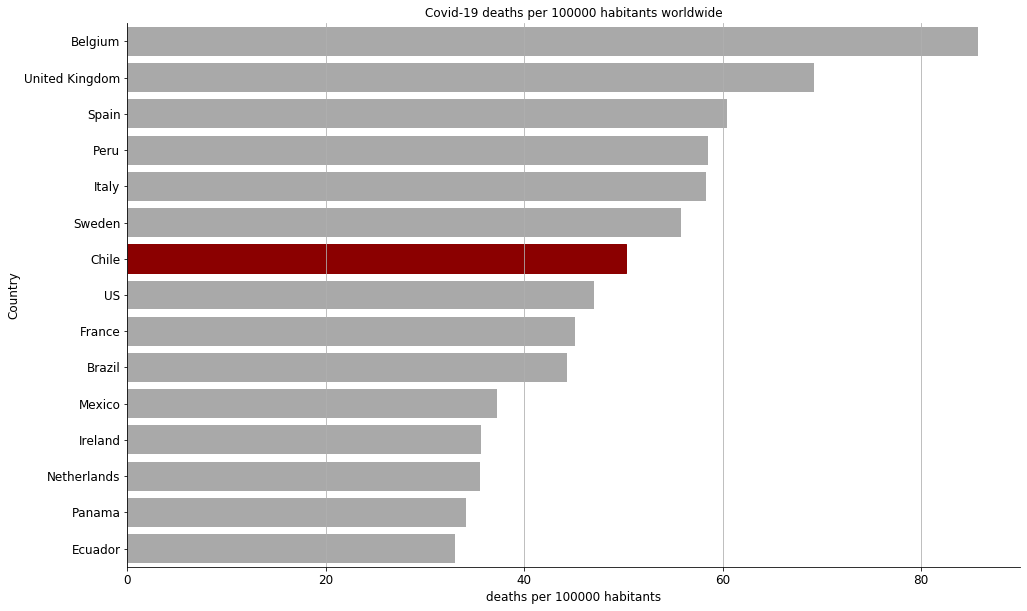

In [8]:
plot_covid_worldwide(csse_deaths_all, 'deaths', 'Chile', 15, 100000, 100000)

### B. Timeline of Covid-19 cases and deaths in Chile 

Next, we will focus on the situation in Chile. Chile is separated into 16 different regions, where "Metropolitana" is the region where the capital Santiago de Chile is located. It becomes clear that the Metropolitan Region is by far most affected by Covid-19.

However, other regions, just like Valparaíso (close to Santiago) and Antofagasta (in the north) experienced a very high rise in cases and deaths. 

In [9]:
def timeline_plot(df, title):
    """
    A function to plot a seaborn diagram which shows the development of Covid-19 data in Chile. 
    For better readability, the function returns a log scale plot. 
    
    Input: 
        df (DataFrame): A transposed DataFrame where the first row (not the index) is the date and the columns are the 
        regions. 
        title (string): Specify the kind of the plot (cases or deaths) 
        
    Output: 
        A seaborn plot. 
    """

    # Transform wide dataframe to long dataframe 
    df_melt = pd.melt(
        df, id_vars = 'Region', 
        value_vars = df.columns.drop('Region'),
        var_name='Regions', 
        value_name='Cases'
    )

    # Apply pandas to datetime and rename column for better understanding
    df_melt['Region'] = pd.to_datetime(df_melt['Region'], format = '%Y-%m-%d')
    df_melt = df_melt.rename(columns = {'Region': 'Date'}).sort_values('Cases', ascending = False)

    # Make a plot 
    f, ax = plt.subplots(figsize = (16, 10))
    g = sns.lineplot(
        df_melt.Date, 
        df_melt.Cases, 
        hue = df_melt.Regions
    )

    plt.xlabel('Date', fontsize = 12)
    plt.ylabel('{}'.format(title), fontsize = 12)
    plt.title('Covid-19 {} in Chile (log scale)'.format(title), fontsize = 12)
    
    plt.tick_params(labelsize=12)
    ax.yaxis.tick_right()
    ax.set_yscale('log')


    plt.grid(False)
    ax.yaxis.grid()
    sns.despine()
    plt.show()
            

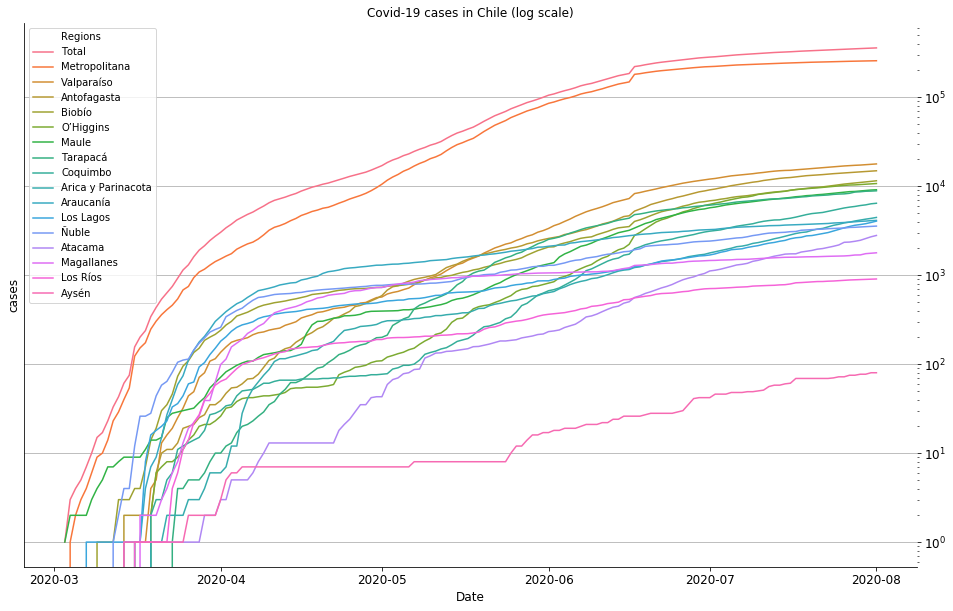

In [10]:
timeline_plot(cases_regions, 'cases')

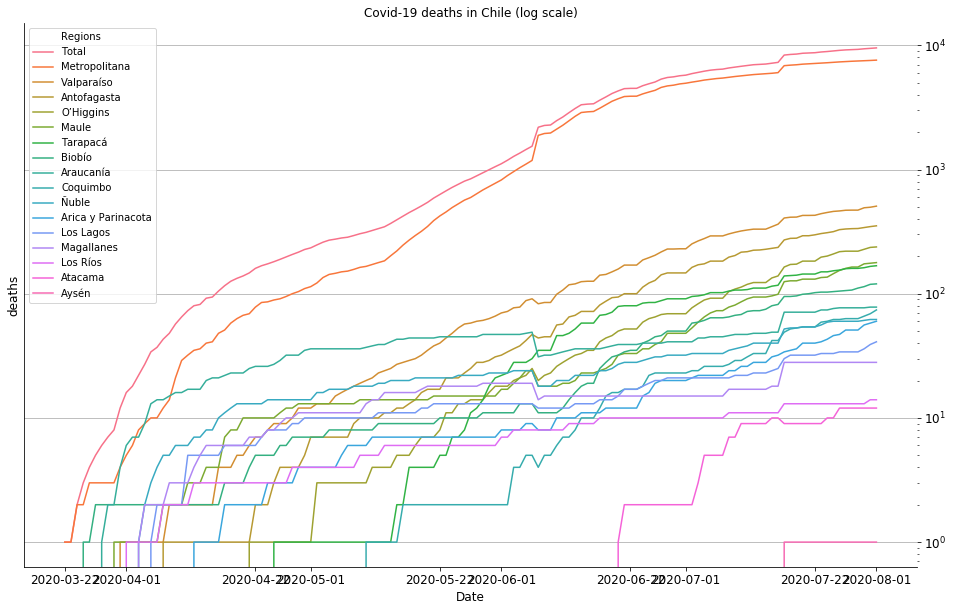

In [11]:
timeline_plot(deaths_regions, 'deaths')

###     B. Which are the 10 most affected districts in Chile, regarding cases and deaths

Looking at the most affected districts in Chile, it is no surprise that they are mainly located in the capital metropolitan zone. 

In [12]:
def get_affected_districts(df, title, m, n=100):
    """
    Function to get the m most or less affected districts. If m is negative, it returns the 10 less affected
    districts. Given that there are still some remote Chilean districts with 0 or only a few Covid-19 cases
    (Antarctic, Easter Islands), I chose a threshold of minimum n cases/deaths to be considered. 
    
    Input: 
        df (DataFrame): DataFrame with information about districts and numbers of cases/deaths
        title (string): Specify the kind of the data (cases or deaths)
        m (int): Returns the m most or less affected districts.
        n (int): Threshold of minimum number of cases/deaths 
        
    Output:
        affected (DataFrame): DataFrame with the m most or less affected districts
    """

    # Get the relevant columns from dataframe and rename them
    df_relevant = df.iloc[:, [0, 2, 3, -2]]
    df_relevant.columns = ['Region', 'District', 'District ID', title]
    
    # If m is positive, return the most affected districts
    if m >= 0:    
        
        # Group by District and drop "index" column
        affected = df_relevant.groupby(
            'District').agg({
            'Region': 'max',
            'District ID': 'max',
            title: 'sum'}).reset_index().sort_values(
            title, ascending = False).head(m).reset_index()

        affected = affected.drop(['index'], axis = 1)  

    else:
        
        # Consider only the districts with more than 10 cases/deaths: 
        df_relevant = df_relevant[df_relevant[df_relevant.columns[-1]] >= n]
        
        # Group by District and drop "index" column
        affected = df_relevant.groupby(
            'District').agg({
            'Region': 'max',
            'District ID': 'max',
            title: 'sum'}).reset_index().sort_values(
            title, ascending = False).tail(m*(-1)).reset_index()

        affected = affected.drop(['index'], axis = 1)  
        
    return affected

In [13]:
get_affected_districts(cases_districts, 'cases', 10, 100)

,District,Region,District ID,cases
0,Puente Alto,Metropolitana,13201.0,22315.0
1,Santiago,Metropolitana,13101.0,14541.0
2,Maipu,Metropolitana,13119.0,14085.0
3,La Florida,Metropolitana,13110.0,13274.0
4,Penalolen,Metropolitana,13122.0,11478.0
5,San Bernardo,Metropolitana,13401.0,10789.0
6,La Pintana,Metropolitana,13112.0,9879.0
7,Pudahuel,Metropolitana,13124.0,9510.0
8,Quilicura,Metropolitana,13125.0,8841.0
9,Recoleta,Metropolitana,13127.0,8275.0


In [14]:
get_affected_districts(deaths_districts, 'deaths', 10, 100)

,District,Region,District ID,deaths
0,Puente Alto,Metropolitana,13201.0,523.0
1,La Florida,Metropolitana,13110.0,431.0
2,Maipu,Metropolitana,13119.0,349.0
3,San Bernardo,Metropolitana,13401.0,306.0
4,Penalolen,Metropolitana,13122.0,292.0
5,Recoleta,Metropolitana,13127.0,290.0
6,La Pintana,Metropolitana,13112.0,289.0
7,Las Condes,Metropolitana,13114.0,274.0
8,Santiago,Metropolitana,13101.0,270.0
9,Nunoa,Metropolitana,13120.0,233.0


## 2. Analyze the CASEN data
### A. A first approach with the CASEN social indicators for the ten most affected districts regarding Covid-19 cases

In a next step, we are going to analyze the correlation between the CASEN data about social vulnerability and Covid-19 cases and deaths in the most affected districts in Chile. 

In our first approach with take the (already long) short list of 46 CASEN indicators and look at their correlation with Covid-19 cases and deaths. 

In [15]:
def show_CASEN_for_districts(df, casen_data, title, m, n): 
    """
    A function to merge a DataFrame with the CASEN data and return an DataFrame with the mean of 
    the different CASEN indicators and the m most affected districts. 
    
    Input: 
        df (DataFrame): DataFrame to provide data about the affected districts
        casen_data (DataFrame): DataFrame with CASEN indicators should be considered. 
        title (string): Type of the above mentioned DataFrame (cases or deaths)
        m (int): Number of how many affected districts you would like to have returned. 
        
    Output: 
        casen_district_grouped (DataFrame): DataFrame with the mean values of the CASEN indicators for the 
        m most affected districts, sorted by the number of cases/deaths. 
        
    """

    # Store 10 most affected districts (cases) in list: 
    top_districts = get_affected_districts(df, title, m, n)
    districts_list = list(top_districts['District ID'])

    # Filter casen_rel DataFrame so it contains only the 10 most affected districts: 
    casen_district = casen_data[casen_data.comuna.isin(districts_list) == True]

    # Return mean value for each indicator
    casen_district_grouped = casen_district.groupby(['comuna'])[[i for i in casen_district.columns[3:]]].mean().reset_index()

    # Merge with data about most affected districts, drop District ID column and sort by cases or deaths
    casen_district_grouped = casen_district_grouped.merge(top_districts, left_on = 'comuna', right_on = 'District ID', how = 'left')
    casen_district_grouped = casen_district_grouped.drop(['District ID'], axis = 1).sort_values(title, ascending = False)
    
    return casen_district_grouped


In [16]:
show_CASEN_for_districts(cases_districts, casen_rel, 'cases', 10, 100)

,comuna,e1,e6a,o1,o12,o16,o25a_min,o25c,o28,y21a,...,v39b,pobreza,hh_d_prevs,hh_d_cot,hh_d_servbas,qaut,numper,District,Region,cases
8,13201,1.038925,9.412603,1.423246,1.513926,1.247863,17.544474,1.553936,1.400219,4.898007,...,1.914976,2.899827,0.071893,0.397575,0.009499,2.971071,4.036269,Puente Alto,Metropolitana,22315.0
0,13101,1.031286,11.087912,1.298635,1.268716,1.222744,19.832151,1.845106,1.465870,4.972782,...,2.137602,2.929220,0.112669,0.262295,0.028694,3.781444,3.078431,Santiago,Metropolitana,14541.0
3,13119,1.040534,9.713341,1.455412,1.262719,1.168317,18.160967,1.563603,1.619456,4.894624,...,1.515364,2.966161,0.092960,0.369976,0.007779,3.122131,3.963827,Maipu,Metropolitana,14085.0
1,13110,1.088595,9.823140,1.442464,1.546889,1.224256,17.694128,1.564752,1.441446,4.891429,...,1.548347,2.941322,0.080579,0.386097,0.014876,3.189256,4.136364,La Florida,Metropolitana,13274.0
4,13122,1.074513,9.583676,1.431837,1.442693,1.233397,18.180516,1.613105,1.536833,4.575472,...,1.696845,2.943681,0.083276,0.431512,0.029533,3.257555,4.354396,Penalolen,Metropolitana,11478.0
9,13401,1.080131,8.694073,1.469338,1.473607,1.255725,17.697947,1.650696,1.372036,4.797639,...,2.152964,2.878904,0.059730,0.358009,0.036966,2.625876,4.408540,San Bernardo,Metropolitana,10789.0
2,13112,1.147757,8.107287,1.480211,1.874396,1.366300,15.567633,1.518717,1.455145,4.679525,...,2.474696,2.802632,0.049595,0.504082,0.016194,2.305668,4.263158,La Pintana,Metropolitana,9879.0
5,13124,1.086667,9.209626,1.426667,1.358407,1.201220,15.743363,1.526185,1.580000,4.860465,...,1.914439,2.887701,0.096257,0.412214,0.007487,2.925134,4.150802,Pudahuel,Metropolitana,9510.0
6,13125,1.033486,8.596450,1.415525,1.161954,1.184300,16.434447,1.758904,1.321157,4.858065,...,2.074556,2.904142,0.049704,0.259172,0.035503,3.036686,3.970414,Quilicura,Metropolitana,8841.0
7,13127,1.107143,9.139140,1.476648,1.249370,1.167785,15.891688,1.755747,1.245879,4.924581,...,1.816742,2.918552,0.097285,0.328409,0.031674,2.955882,3.520362,Recoleta,Metropolitana,8275.0


In [17]:
show_CASEN_for_districts(deaths_districts, casen_rel, 'deaths', 10, 100)

,comuna,e1,e6a,o1,o12,o16,o25a_min,o25c,o28,y21a,...,v39b,pobreza,hh_d_prevs,hh_d_cot,hh_d_servbas,qaut,numper,District,Region,deaths
8,13201,1.038925,9.412603,1.423246,1.513926,1.247863,17.544474,1.553936,1.400219,4.898007,...,1.914976,2.899827,0.071893,0.397575,0.009499,2.971071,4.036269,Puente Alto,Metropolitana,523.0
1,13110,1.088595,9.823140,1.442464,1.546889,1.224256,17.694128,1.564752,1.441446,4.891429,...,1.548347,2.941322,0.080579,0.386097,0.014876,3.189256,4.136364,La Florida,Metropolitana,431.0
4,13119,1.040534,9.713341,1.455412,1.262719,1.168317,18.160967,1.563603,1.619456,4.894624,...,1.515364,2.966161,0.092960,0.369976,0.007779,3.122131,3.963827,Maipu,Metropolitana,349.0
9,13401,1.080131,8.694073,1.469338,1.473607,1.255725,17.697947,1.650696,1.372036,4.797639,...,2.152964,2.878904,0.059730,0.358009,0.036966,2.625876,4.408540,San Bernardo,Metropolitana,306.0
6,13122,1.074513,9.583676,1.431837,1.442693,1.233397,18.180516,1.613105,1.536833,4.575472,...,1.696845,2.943681,0.083276,0.431512,0.029533,3.257555,4.354396,Penalolen,Metropolitana,292.0
7,13127,1.107143,9.139140,1.476648,1.249370,1.167785,15.891688,1.755747,1.245879,4.924581,...,1.816742,2.918552,0.097285,0.328409,0.031674,2.955882,3.520362,Recoleta,Metropolitana,290.0
2,13112,1.147757,8.107287,1.480211,1.874396,1.366300,15.567633,1.518717,1.455145,4.679525,...,2.474696,2.802632,0.049595,0.504082,0.016194,2.305668,4.263158,La Pintana,Metropolitana,289.0
3,13114,1.023915,12.064947,1.426029,1.222120,1.154545,18.756682,1.868308,1.516129,5.114548,...,1.715339,2.996248,0.023932,0.199525,0.020686,4.492495,3.594747,Las Condes,Metropolitana,274.0
0,13101,1.031286,11.087912,1.298635,1.268716,1.222744,19.832151,1.845106,1.465870,4.972782,...,2.137602,2.929220,0.112669,0.262295,0.028694,3.781444,3.078431,Santiago,Metropolitana,270.0
5,13120,1.022302,11.523667,1.378417,1.398004,1.222714,20.225055,1.792079,1.373381,5.173611,...,1.925704,2.981982,0.058965,0.266066,0.004805,4.175976,3.312312,Nunoa,Metropolitana,233.0


In [18]:
def show_corr(df, casen_rel, title, m, n): 
    """
    Function to show the correlation between CASEN data and the number of Covid-19 cases/deaths
    in the m most affected districts. 
    
    Input:
        df (DataFrame): DataFrame to provide data about the affected districts
        casen_data (DataFrame): DataFrame with CASEN indicators should be considered. 
        title (string): Type of the above mentioned DataFrame (cases or deaths)
        m (int): Number of how many affected districts you would like to have returned. 

    Output: 
        corr (Series): Sorted pandas series that shows the correlation between Covid-19 cases/deaths
        and the different CASEN indicators. 
    """

    # Get CASEN data for m most affected districts and drop the columns that are not need
    top_10_corr = show_CASEN_for_districts(df, casen_rel, title, m, n)
    corr_data = top_10_corr.drop(['comuna', 'District', 'Region', title], axis = 1)

    # Sort values from highest correlation to lowest
    corr = top_10_corr.corrwith(top_10_corr[title]).sort_values(ascending = False)
    
    return corr

In [19]:
show_corr(cases_districts, casen_rel, 'cases', 10, 100).head()

cases       1.000000
o25a_min    0.514524
e6a         0.435303
s12         0.402356
v37c        0.396055
dtype: float64

In [20]:
show_corr(deaths_districts, casen_rel, 'deaths', 10, 100).head()

deaths      1.000000
v37i        0.533666
numper      0.395689
hh_d_cot    0.372405
y24         0.346933
dtype: float64

### B. Analyze six selected CASEN social indicators for the ten most affected districts regarding Covid-19 cases 

Now we have some CASEN indicators - interestingly not the same - that have the highest correlation with Covid-19 cases and deaths in Chile. 

In a next step, we take a closer look to the four indicators with the highest correlation. These are: 

Cases:
* o25a_min: Commuting time
* e6a: Education
* s12: Health insurance system

Deaths: 
* v37i: Distance to next pharmacy (less than 2,5km?)
* numper: Number of persons in household
* hh_d_cot: Social security system yes/no

In [21]:
# Lets focus on the three CASEN indicators, that showed the highest correlation with Covid-19 cases and deaths
# in Chile: o25a_min, e6a, s12, v37i, numper, hh_d_cot
casen_sel_in = casen_rel[['comuna', 'o25a_min', 'e6a', 's12', 'v37i', 'numper', 'hh_d_cot']]

In [22]:
# Then we can make use of the before defined function "first_look" and we see that o25a_min a lot of NaNs has. 
first_look([casen_sel_in])

Information for DataFrame casen_sel_in
The shape of this DataFrame is (216439, 7).
NaN share for each column:
comuna      0.000000
o25a_min    0.573011
e6a         0.000000
s12         0.000000
v37i        0.000000
numper      0.000961
hh_d_cot    0.013884
dtype: float64
Describe() for each column:
              comuna      o25a_min            e6a            s12  \
count  216439.000000  92417.000000  216439.000000  216439.000000   
mean     9004.354456     16.794518       9.121923       5.449716   
std      4181.203296     14.943926       5.804464      14.829401   
min      1101.000000      0.000000       1.000000       1.000000   
25%      5804.000000      1.000000       7.000000       2.000000   
50%      9101.000000     15.000000       9.000000       2.000000   
75%     13115.000000     30.000000      11.000000       5.000000   
max     16305.000000     99.000000      99.000000      99.000000   

                v37i         numper       hh_d_cot  
count  216439.000000  216231.00000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023B803AFDD8>,
      dtype=object)

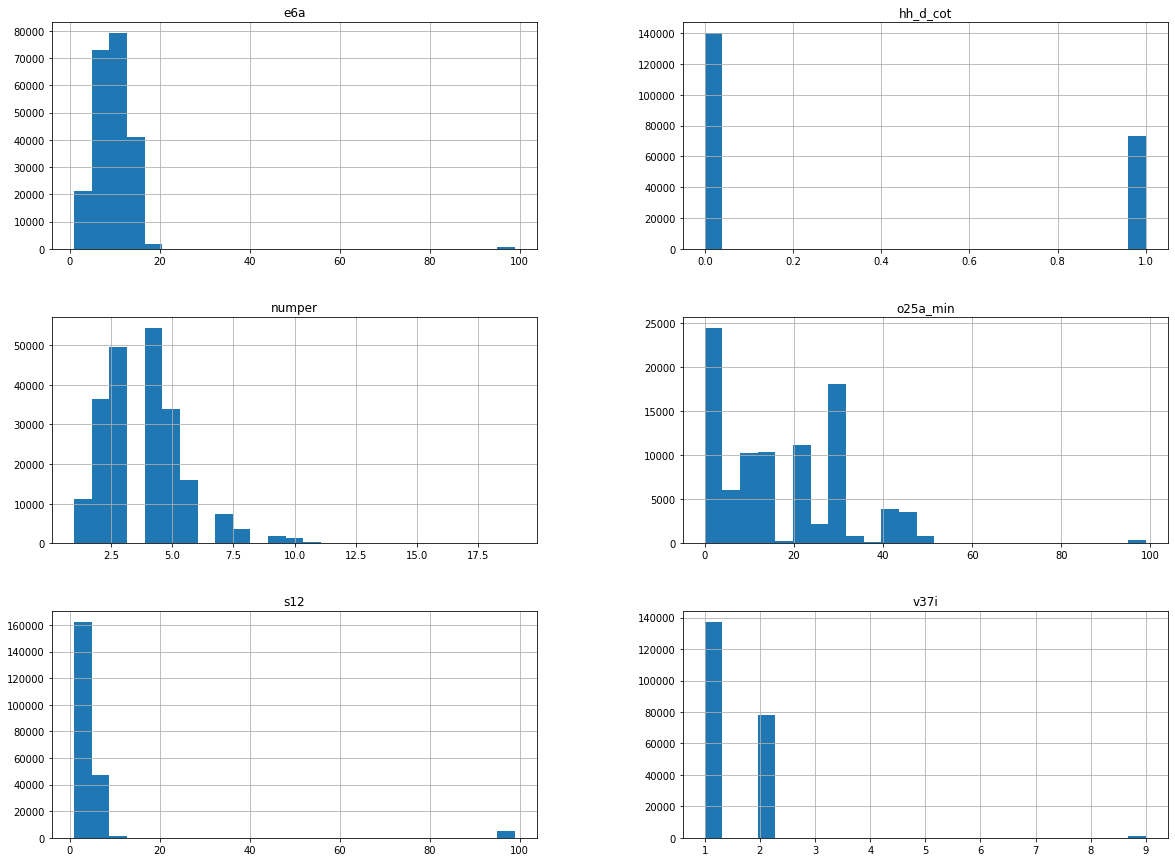

In [23]:
casen_sel_in.drop(['comuna'], axis = 1).hist(figsize = (20, 15), bins = 25)

16.794518324550676


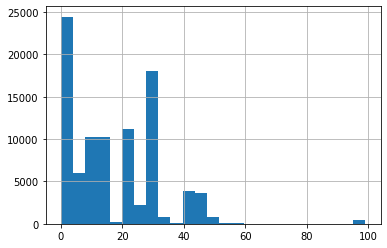

In [24]:
# The column o25a_min has a lot of NaNs, the mean commuting time is about 16 minutes. 
print(casen_sel_in['o25a_min'].mean())

casen_sel_in['o25a_min'].hist(bins = 25)

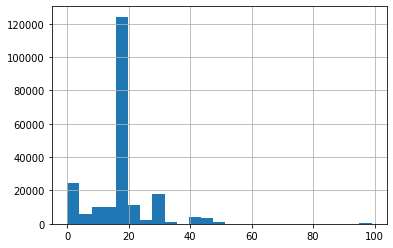

In [25]:
# Given that the NaNs could change the correlation, we fill them with the mean of the column. 
casen_sel_in['o25a_min'] = casen_sel_in['o25a_min'].fillna(casen_sel_in['o25a_min'].mean())

casen_sel_in['o25a_min'].hist(bins = 25)

AxesSubplot(0.125,0.125;0.775x0.755)


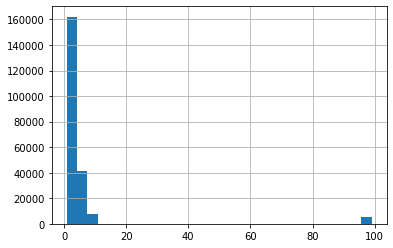

In [26]:
# The s12 column is also a very interesting case. It contains values between 1 and 7, where 1 is the 
# most basic health insurance system and 7 the most extensive system. However, 8 (no health insurance) and 9 
# (other system) do not provide more services than number 7, so its no continuous scale. 
print(casen_sel_in['s12'].hist(bins = 30))

In [27]:
# We have to add therefore more columns following the one hot encoding approach.
# With the get_dummies method, we can create some dummy columns for the different health insurance systems: 
casen_sel_in_final = pd.concat([casen_sel_in, pd.get_dummies(casen_sel_in['s12'])], axis = 1).drop(['s12'], axis = 1)

casen_sel_in_final.head()

,comuna,o25a_min,e6a,v37i,numper,hh_d_cot,1,2,3,4,5,6,7,8,9,99
0,1101,10.0,9,1,1.0,1.0,0,0,0,0,0,0,0,0,0,1
1,1101,10.0,7,2,1.0,1.0,0,0,0,0,0,0,0,1,0,0
2,1101,10.0,9,1,2.0,1.0,0,0,0,0,0,0,0,0,0,1
3,1101,10.0,9,1,2.0,1.0,0,0,0,0,0,0,0,0,0,1
4,1101,40.0,13,1,3.0,0.0,0,1,0,0,0,0,0,0,0,0


### C. Show correlation between six selected CASEN social indicators and cases/deaths for most affected districts regarding Covid-19 cases 

Now that we have the DataFrame with the prepared data (filled in the NaNs with o25a_min and one hot encoding for the health insurance system, we can call again the functions to show the correlations between those indicators and the Covid-19 cases/deaths in Chile. 

In [28]:
show_corr(cases_districts, casen_sel_in_final, 'cases', 10, 100)

cases       1.000000
7           0.436913
4           0.404304
99          0.316435
v37i        0.305149
9           0.239811
comuna      0.086783
8           0.063874
5           0.056514
hh_d_cot    0.045366
2           0.008434
6          -0.068966
numper     -0.103592
3          -0.253573
1          -0.397552
dtype: float64

In [29]:
show_corr(deaths_districts, casen_sel_in_final, 'deaths', 10, 100)

deaths      1.000000
2           0.561165
v37i        0.533666
numper      0.395689
3           0.389918
4           0.383263
hh_d_cot    0.372405
comuna      0.148420
1           0.076871
99         -0.086933
5          -0.112756
8          -0.154749
6          -0.265842
9          -0.269422
7          -0.305798
dtype: float64

## 3. Analyze the CASEN data: The ten less affected districts

### A. Correlation between the CASEN social indicators and cases/deaths in the ten less affected districts

In [30]:
get_affected_districts(cases_districts, 'cases', -10, 100)

,District,Region,District ID,cases
0,Algarrobo,Valparaíso,5602.0,110.0
1,Rauco,Maule,7305.0,108.0
2,Quinta de Tilcoco,O’Higgins,6114.0,107.0
3,Villarrica,Araucanía,9120.0,107.0
4,Carahue,Araucanía,9102.0,103.0
5,Pemuco,Ñuble,16105.0,103.0
6,El Carmen,Ñuble,16104.0,102.0
7,Pitrufquen,Araucanía,9114.0,100.0
8,La Union,Los Ríos,14201.0,100.0
9,Rio Claro,Maule,7108.0,100.0


In [31]:
get_affected_districts(deaths_districts, 'deaths', -10, 20)

,District,Region,District ID,deaths
0,Quilpue,Valparaiso,5801.0,32.0
1,Quillota,Valparaiso,5501.0,32.0
2,Curico,Maule,7301.0,31.0
3,Concepcion,Biobio,8101.0,28.0
4,Punta Arenas,Magallanes y la Antartica,12101.0,28.0
5,Pirque,Metropolitana,13202.0,26.0
6,Talca,Maule,7101.0,26.0
7,San Felipe,Valparaiso,5701.0,24.0
8,Temuco,La Araucania,9101.0,24.0
9,Ovalle,Coquimbo,4301.0,21.0


In [32]:
show_corr(cases_districts, casen_rel, 'cases', 10, 100).head()

cases       1.000000
o25a_min    0.514524
e6a         0.435303
s12         0.402356
v37c        0.396055
dtype: float64

In [53]:
show_corr(cases_districts, casen_rel, 'cases', -10, 100).head()

cases    1.000000
s13      0.803434
ytot     0.750788
qaut     0.653942
s31a1    0.511752
dtype: float64

In [59]:
casen_rel_less = casen_rel[['o25a_min', 'e6a', 's12', 's13', 'ytot', 'qaut']]

print(first_look([casen_rel_less]))

Information for DataFrame casen_rel_less
The shape of this DataFrame is (216439, 6).
NaN share for each column:
o25a_min    0.573011
e6a         0.000000
s12         0.000000
s13         0.000000
ytot        0.331424
qaut        0.000961
dtype: float64
Describe() for each column:
           o25a_min            e6a            s12            s13  \
count  92417.000000  216439.000000  216439.000000  216439.000000   
mean      16.794518       9.121923       5.449716       5.788883   
std       14.943926       5.804464      14.829401       1.321671   
min        0.000000       1.000000       1.000000       1.000000   
25%        1.000000       7.000000       2.000000       5.000000   
50%       15.000000       9.000000       2.000000       6.000000   
75%       30.000000      11.000000       5.000000       7.000000   
max       99.000000      99.000000      99.000000       9.000000   

               ytot           qaut  
count  1.447060e+05  216231.000000  
mean   4.039880e+05       2.7410

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023B80A6FBE0>,
      dtype=object)

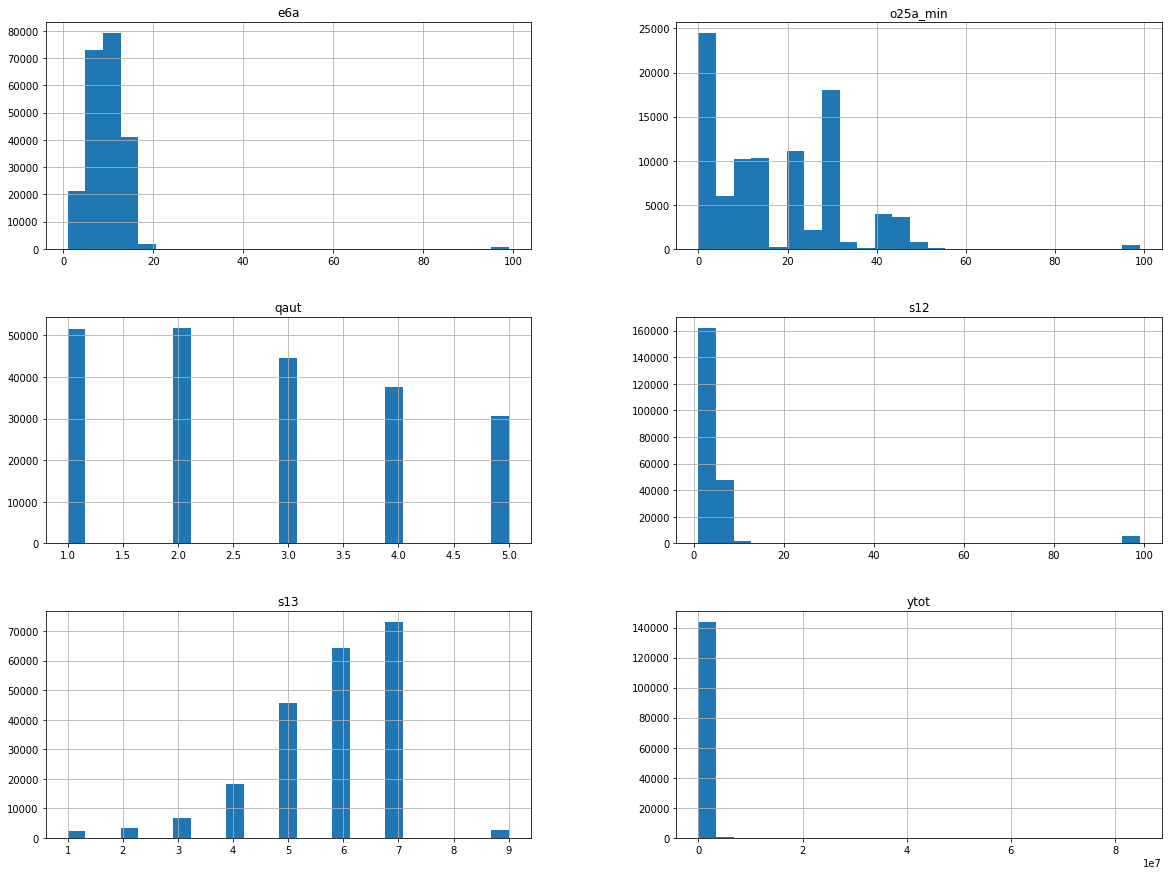

In [61]:
casen_rel_less.hist(figsize = (20, 15), bins = 25)